In [99]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from ultimation import model_selection
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
model_list = [LinearRegression(), KNeighborsRegressor(n_neighbors=3, n_jobs=10), KNeighborsRegressor(n_neighbors=5, n_jobs=10), KNeighborsRegressor(n_neighbors=7, n_jobs=10), MLPRegressor(hidden_layer_sizes=(100,), alpha=0.0001, learning_rate_init=0.001, random_state=42), RandomForestRegressor(), XGBRegressor(n_estimators = 1000), XGBRegressor(), XGBRegressor(n_estimators=1000, learning_rate=0.05)]

In [2]:
data = pd.read_csv('train_boston latest.csv')

In [3]:
data.columns = map(lambda x : x.strip(), data.columns)

In [4]:
data['zip_code'] = data['zip_code'].astype('category')
data['data'] = pd.to_datetime(data['data'])
data['data'] = data['data'].dt.month

In [5]:
data['yr_renovated'] = data['yr_renovated'].apply(lambda x: 1 if 0 < x < 2000 else 2 if x >= 2000 else 0)
data['yr_renovated'].value_counts()

0    16550
2      368
1      358
Name: yr_renovated, dtype: int64

In [6]:
data['floors'] = data['floors'].apply(lambda x: 1 if x < 2 else 2 if 2 <= x < 3 else 3)

In [7]:
data['bathrooms'] = data['bathrooms'].astype('category')
data['floors'] = data['floors'].astype('category')
data['view'] = data['view'].astype('category')
data['condition'] = data['condition'].astype('category')
data['grade'] = data['grade'].astype('category')

In [8]:
#data['basement'] = data['sqft_basement'].apply(lambda x: 1 if 0 < x else 0)

In [9]:
data['sqft_basement'] = data['sqft_basement'].apply(lambda x: 1 if 0 < x else 0)

In [10]:
data = data.set_index('index', drop = True)

In [11]:
def remove_outliers(df, threshold=1.5, in_columns=[], skip_columns=[]):
    
    if len(in_columns) == 0:
        in_columns = df.select_dtypes(np.number).columns
        
    for column in in_columns:
        if column not in skip_columns:
            print(column)
            upper = np.percentile(df[column],75)
            lower = np.percentile(df[column],25)
            iqr = upper - lower
            upper_limit = upper + threshold * iqr
            lower_limit = lower - threshold * iqr
            print(upper_limit, lower_limit)
            df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
            print(len(df))
    return df

In [12]:
data = remove_outliers(data, threshold=1.5, in_columns=['bedrooms', 'sqft_living',
       'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price'], skip_columns=['data', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'yr_built', 'yr_renovated', 'zip_code', 'lat', 'lon', 'basement'])

bedrooms
5.5 1.5
16857
sqft_living
4205.0 -235.0
16419
sqft_lot
18375.0 -3025.0
14647
sqft_above
3377.5 -170.5
14311
sqft_basement
2.5 -1.5
14311
sqft_living15
3300.0 340.0
14075
sqft_lot15
14813.0 -1151.0
13712
price
989331.25 -102218.75
13250


In [13]:
data['bedrooms'] = data['bedrooms'].astype('category')
data = data.drop('id', axis = 1)

In [26]:
def funky_function4_1_4(data, model_list):
    X = pd.get_dummies(data.drop('price', axis=1))
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train, X_test = (scaler.transform(X_train), scaler.transform(X_test))
    results = {}
    results_mae = {}
    results_mse = {}
    for model in model_list:
        model.fit(X_train, y_train)
        results[model] = model.score(X_test, y_test)
        print(model, 'R2 score:', model.score(X_test, y_test))
        y_pred = model.predict(X_test)
        results2 = mean_absolute_error(y_test, y_pred)
        results3 = mean_squared_error(y_test, y_pred, squared=False)
        print('Mean Absolute Error:', results2)
        print('Mean Squared Error:', results3)
        results_mae[model] = results2
        results_mse[model] = results3
        plt.figure(figsize=(10,8))
        sns.regplot(x=y_pred, y=y_test, line_kws={"color": "orange"})
        plt.xlabel('Actual Values ')
        plt.ylabel('Predictions ')
        plt.title('Linear Model Predictions vs Actual')
        plt.show()
    final_result_r2 = max(results.values())
    final_result_mae = min(results_mae.values())
    final_result_mse = min(results_mse.values())
    print("--------------------------------------------------------------------------------------------------------")
    print('TAA DAAA!! AND THE WINNER IIIISSSSS:')
    print("--------------------------------------------------------------------------------------------------------")
    best_mae_model = min(results_mae, key=results_mae.get)
    best_r2_model = max(results, key=results.get)
    best_mse_model = min(results_mse, key=results_mse.get)
    print('Best R2:', best_r2_model, final_result_r2)
    print('Best Mean Absolute Error:', best_mae_model, final_result_mae)
    print('Best Mean Squared Error:', best_mse_model, final_result_mse)
    plt.figure(figsize=(10,8))
    sns.regplot(x=best_r2_model.predict(X_test), y=y_test, line_kws={"color": "orange"})
    plt.xlabel('Actual Values ')
    plt.ylabel('Predictions ')
    plt.title('Linear Model R2 Predictions vs Actual')
    plt.show()
    plt.figure(figsize=(10,8))
    sns.regplot(x=best_mae_model.predict(X_test), y=y_test, line_kws={"color": "green"})
    plt.xlabel('Actual Values ')
    plt.ylabel('Predictions ')
    plt.title('Linear Model MAE Predictions vs Actual')
    plt.show()
    plt.figure(figsize=(10,8))
    sns.regplot(x=best_mse_model.predict(X_test), y=y_test, line_kws={"color": "yellow"})
    plt.xlabel('Actual Values ')
    plt.ylabel('Predictions ')
    plt.title('Linear Model MSE Predictions vs Actual')
    plt.show()
    return best_mae_model, best_mse_model, best_r2_model

In [65]:
def funky_function4_1_4_2(data, model_list):
    X = pd.get_dummies(data.drop('price', axis=1))
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train, X_test = (scaler.transform(X_train), scaler.transform(X_test))
    results = {}
    results_mae = {}
    results_mse = {}
    for model in model_list:
        model.fit(X_train, y_train)
        results[model] = model.score(X_test, y_test)
        print(model, 'R2 score:', model.score(X_test, y_test))
        y_pred = model.predict(X_test)
        results2 = mean_absolute_error(y_test, y_pred)
        results3 = mean_squared_error(y_test, y_pred, squared=False)
        print('Mean Absolute Error:', results2)
        print('Mean Squared Error:', results3)
        results_mae[model] = results2
        results_mse[model] = results3
    final_result_r2 = max(results.values())
    final_result_mae = min(results_mae.values())
    final_result_mse = min(results_mse.values())
    print("--------------------------------------------------------------------------------------------------------")
    print('TAA DAAA!! AND THE WINNER IIIISSSSS:')
    print("--------------------------------------------------------------------------------------------------------")
    best_mae_model = min(results_mae, key=results_mae.get)
    best_r2_model = max(results, key=results.get)
    best_mse_model = min(results_mse, key=results_mse.get)
    print('Best R2:', best_r2_model, final_result_r2)
    print('Best Mean Absolute Error:', best_mae_model, final_result_mae)
    print('Best Mean Squared Error:', best_mse_model, final_result_mse)
    return best_mae_model, best_mse_model, best_r2_model

In [96]:
def funky_function4_1_4_1(data, model_list):
    X = data.drop('price', axis=1) # assuming you named your target variable as 'price'
    y = data['price']
    numericals = X.select_dtypes(np.number)
    categoricals = X.select_dtypes(['object', 'category'])
    print(categoricals.columns)
    
    enc = OneHotEncoder(handle_unknown = 'ignore')
    enc_df = pd.DataFrame(enc.fit_transform(categoricals).toarray())
    
    with open('encoder.pkl', 'wb') as file:
        pickle.dump(enc, file)

    
    X = numericals.reset_index(drop = True).merge(enc_df, right_index = True, left_index = True)
    
      
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    with open('transformer.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    
    X_train, X_test = (scaler.transform(X_train), scaler.transform(X_test))
    #numericals = np.concatenate([X_train, X_test])
    # make sure the concatenation is in the same order as the one you used to train your model
    #X_transformed = pd.concat(enc_df, numericals)  
    #X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=42)
    
    results = {}
    results_mae = {}
    results_mse = {}
    for model in model_list:
        model.fit(X_train, y_train)
        results[model] = model.score(X_test, y_test)
        print(model, 'R2 score:', model.score(X_test, y_test))
        y_pred = model.predict(X_test)
        results2 = mean_absolute_error(y_test, y_pred)
        results3 = mean_squared_error(y_test, y_pred, squared=False)
        print('Mean Absolute Error:', results2)
        print('Mean Squared Error:', results3)
        results_mae[model] = results2
        results_mse[model] = results3
        plt.figure(figsize=(10,8))
        sns.regplot(x=y_pred, y=y_test, line_kws={"color": "orange"})
        plt.xlabel('Actual Values ')
        plt.ylabel('Predictions ')
        plt.title('Linear Model Predictions vs Actual')
        plt.show()
    final_result_r2 = max(results.values())
    final_result_mae = min(results_mae.values())
    final_result_mse = min(results_mse.values())
    print("--------------------------------------------------------------------------------------------------------")
    print('TAA DAAA!! AND THE WINNER IIIISSSSS:')
    print("--------------------------------------------------------------------------------------------------------")
    best_mae_model = min(results_mae, key=results_mae.get)
    best_r2_model = max(results, key=results.get)
    best_mse_model = min(results_mse, key=results_mse.get)
    print('Best R2:', best_r2_model, final_result_r2)
    print('Best Mean Absolute Error:', best_mae_model, final_result_mae)
    print('Best Mean Squared Error:', best_mse_model, final_result_mse)
    plt.figure(figsize=(10,8))
    sns.regplot(x=best_r2_model.predict(X_test), y=y_test, line_kws={"color": "orange"})
    plt.xlabel('Actual Values ')
    plt.ylabel('Predictions ')
    plt.title('Linear Model R2 Predictions vs Actual')
    plt.show()
    plt.figure(figsize=(10,8))
    sns.regplot(x=best_mae_model.predict(X_test), y=y_test, line_kws={"color": "green"})
    plt.xlabel('Actual Values ')
    plt.ylabel('Predictions ')
    plt.title('Linear Model MAE Predictions vs Actual')
    plt.show()
    plt.figure(figsize=(10,8))
    sns.regplot(x=best_mse_model.predict(X_test), y=y_test, line_kws={"color": "yellow"})
    plt.xlabel('Actual Values ')
    plt.ylabel('Predictions ')
    plt.title('Linear Model MSE Predictions vs Actual')
    plt.show()
    return best_mae_model, best_mse_model, best_r2_model

Index(['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade',
       'zip_code'],
      dtype='object')
LinearRegression() R2 score: 0.8370742192327365
Mean Absolute Error: 55502.73830778285
Mean Squared Error: 74063.65286499835


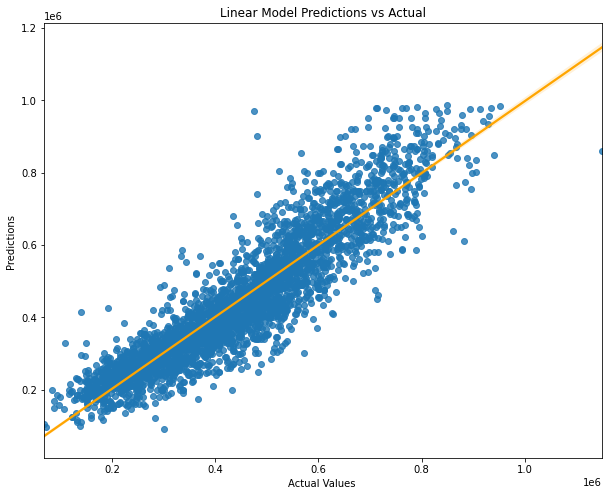

KNeighborsRegressor(n_jobs=10, n_neighbors=3) R2 score: 0.7594804290673349
Mean Absolute Error: 63553.85421068518
Mean Squared Error: 89988.17260977735


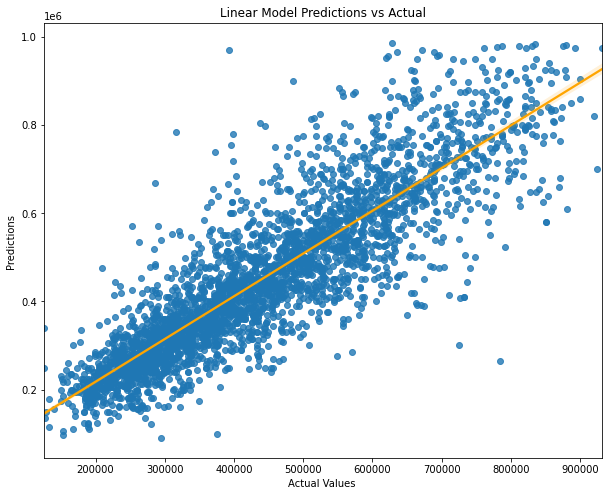

KNeighborsRegressor(n_jobs=10) R2 score: 0.770891497675443
Mean Absolute Error: 62416.807968608504
Mean Squared Error: 87827.56165357577


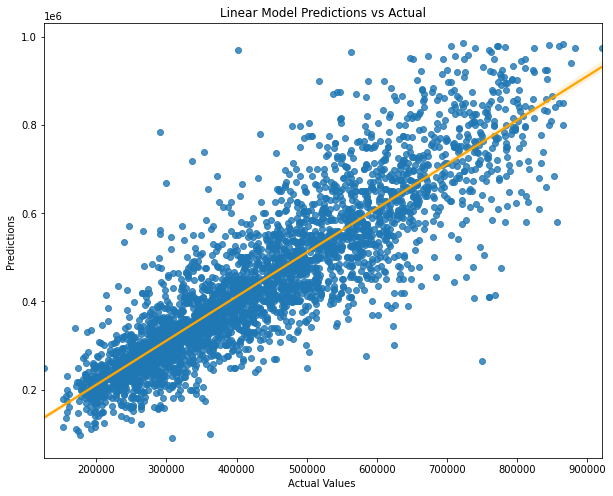

KNeighborsRegressor(n_jobs=10, n_neighbors=7) R2 score: 0.7795768791774111
Mean Absolute Error: 61342.60734767798
Mean Squared Error: 86146.72980735317


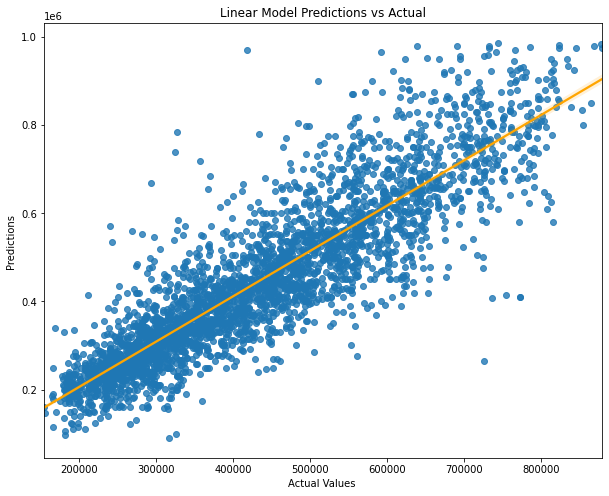

MLPRegressor(random_state=42) R2 score: -3.4988731290827824
Mean Absolute Error: 363486.89207890676
Mean Squared Error: 389190.378755709


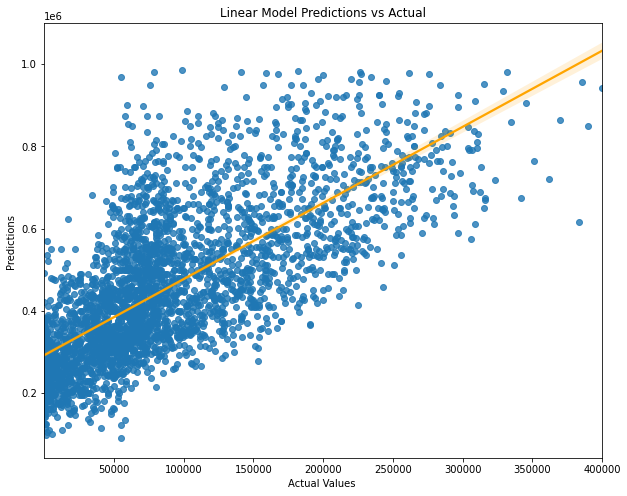

RandomForestRegressor() R2 score: 0.8555807688154561
Mean Absolute Error: 49194.99046634471
Mean Squared Error: 69730.49317813011


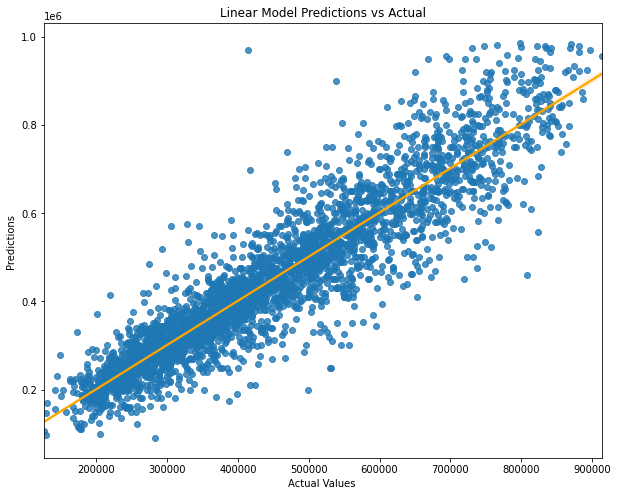

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) R2 score: 0.8627448309028941
Mean Absolute Error: 48379.67782928992
Mean Squared Error: 67978.96954300713


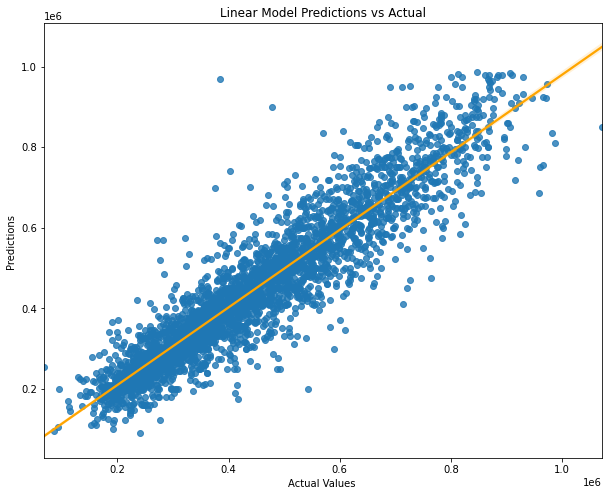

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) R2 score: 0.8728735153932954
Mean Absolute Error: 46507.459060424844
Mean Squared Error: 65422.66652915558


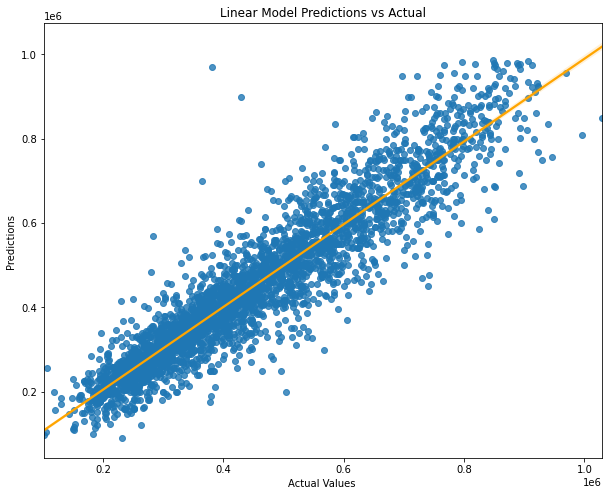

--------------------------------------------------------------------------------------------------------
TAA DAAA!! AND THE WINNER IIIISSSSS:
--------------------------------------------------------------------------------------------------------
Best R2: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 0.8728735153932954
Best Mean Absolute Error: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gam

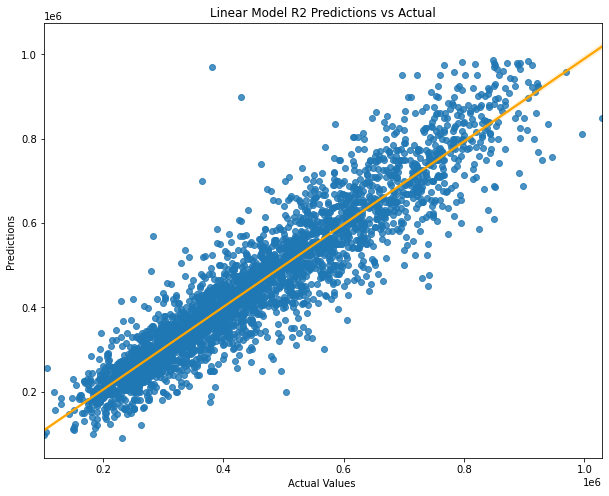

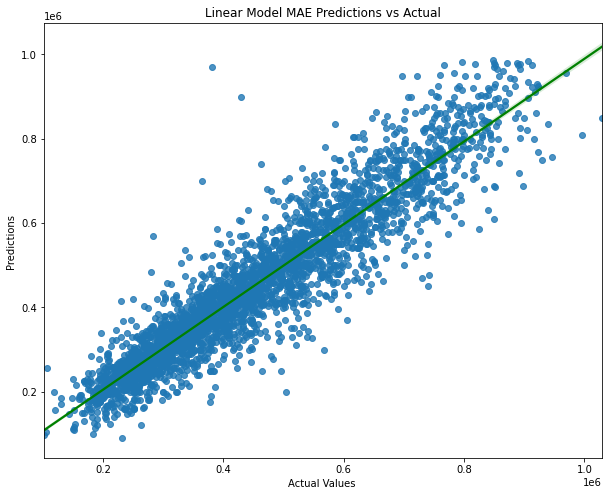

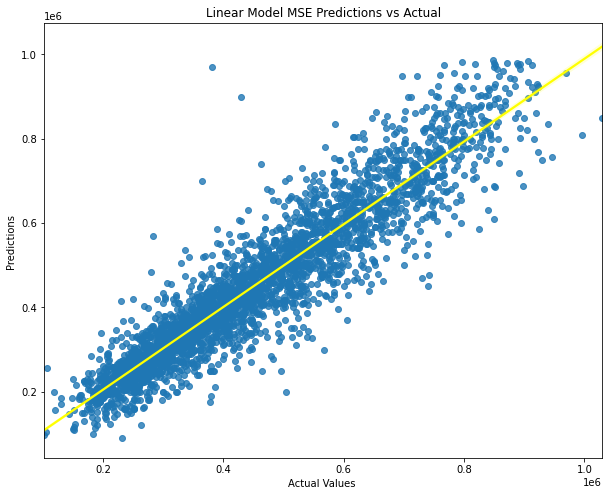

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=

In [97]:
funky_function4_1_4_1(data, model_list)

LinearRegression() R2 score: 0.8369396565509097
Mean Absolute Error: 55475.13435014713
Mean Squared Error: 74094.23165600073


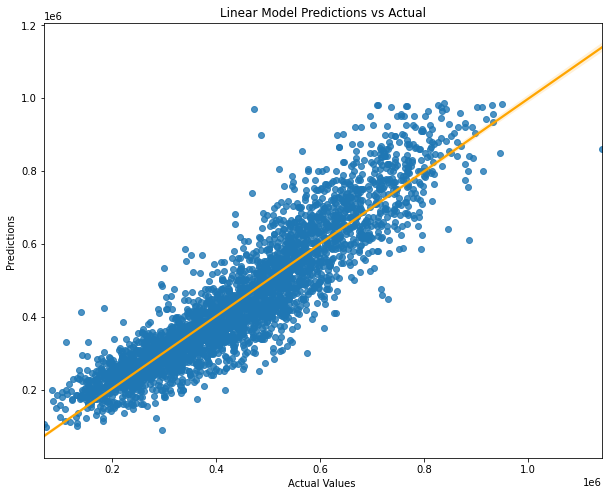

KNeighborsRegressor(n_jobs=10, n_neighbors=3) R2 score: 0.7594804290673349
Mean Absolute Error: 63553.85421068518
Mean Squared Error: 89988.17260977735


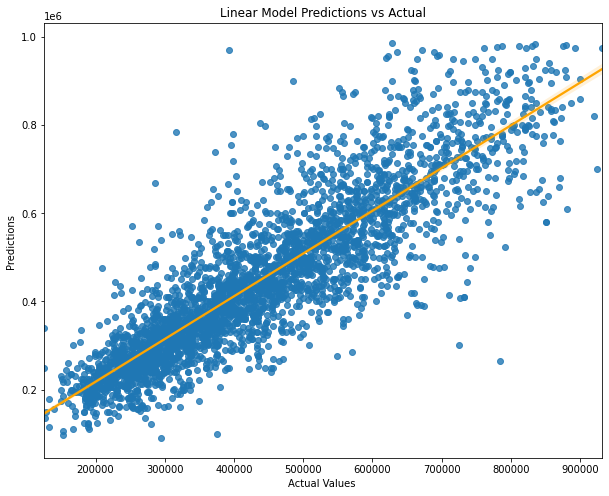

KeyboardInterrupt: 

In [67]:
funky_function4_1_4(data, model_list)

### Best result:

Best R2: XGBRegressor() 0.8834705290153213
Best Mean Absolute Error: XGBRegressor() 44256.123964778904
Best Mean Squared Error: XGBRegressor() 62636.59052604274

Index(['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade',
       'zip_code'],
      dtype='object')
LinearRegression() R2 score: 0.8370742192327365
Mean Absolute Error: 55502.73830778285
Mean Squared Error: 74063.65286499835


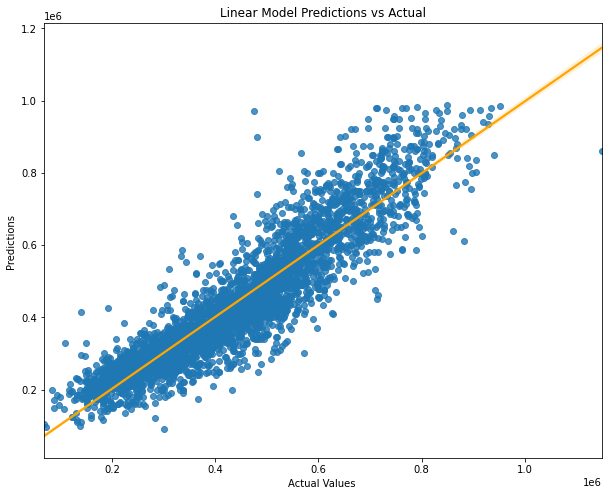

KNeighborsRegressor(n_jobs=10, n_neighbors=3) R2 score: 0.7594804290673349
Mean Absolute Error: 63553.85421068518
Mean Squared Error: 89988.17260977735


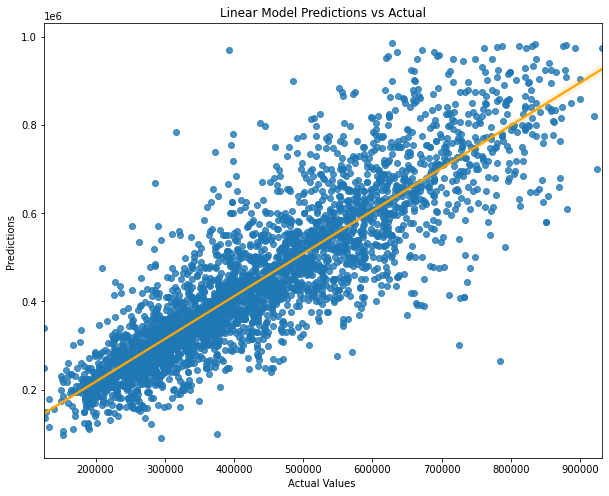

KNeighborsRegressor(n_jobs=10) R2 score: 0.770891497675443
Mean Absolute Error: 62416.807968608504
Mean Squared Error: 87827.56165357577


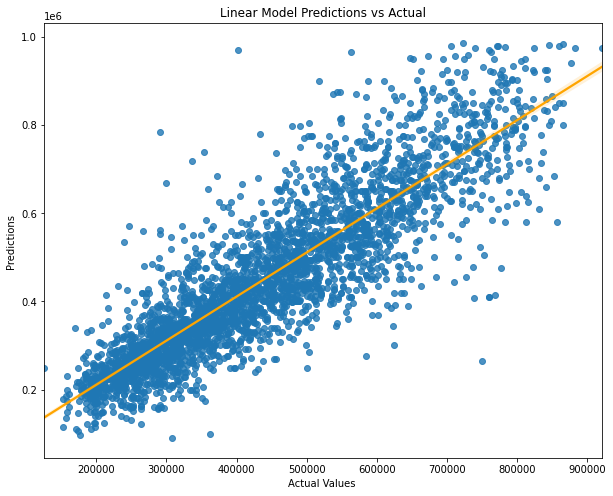

KNeighborsRegressor(n_jobs=10, n_neighbors=7) R2 score: 0.7795768791774111
Mean Absolute Error: 61342.60734767798
Mean Squared Error: 86146.72980735317


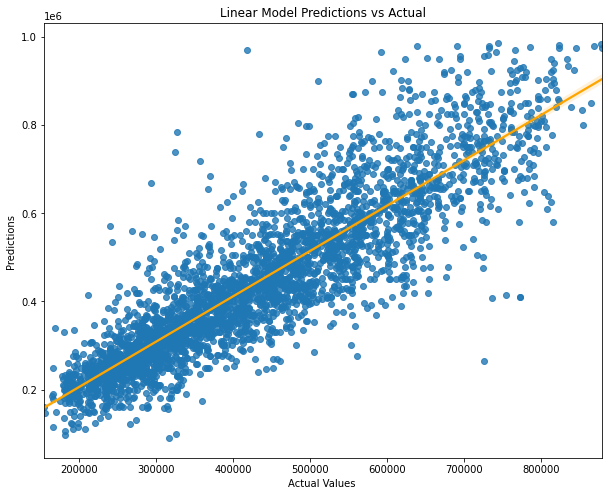

MLPRegressor(random_state=42) R2 score: -3.4988731290827824
Mean Absolute Error: 363486.89207890676
Mean Squared Error: 389190.378755709


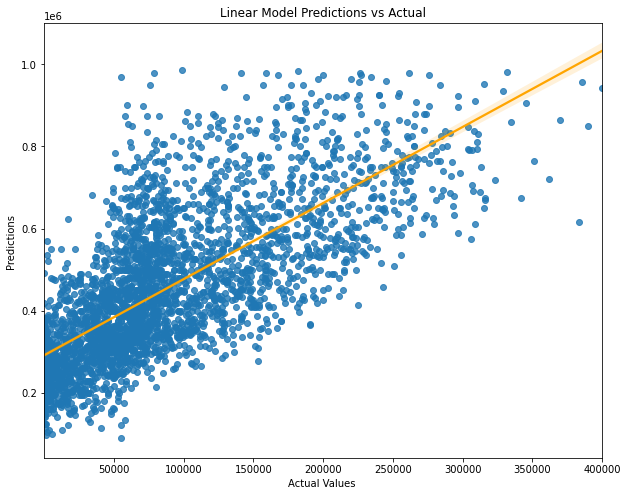

RandomForestRegressor() R2 score: 0.8556267839597054
Mean Absolute Error: 49113.72177859946
Mean Squared Error: 69719.38345851768


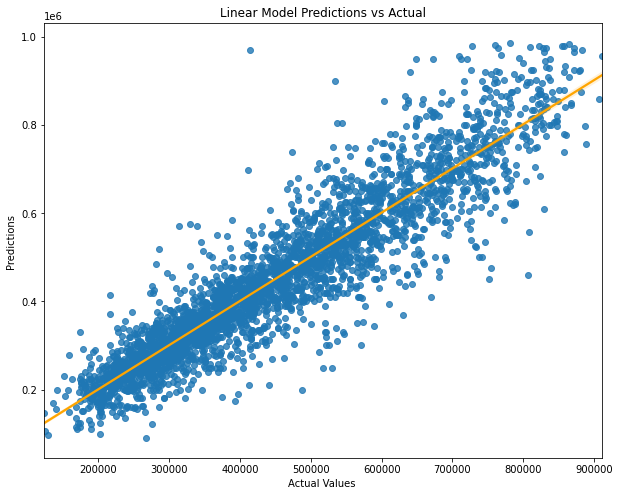

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) R2 score: 0.8627448309028941
Mean Absolute Error: 48379.67782928992
Mean Squared Error: 67978.96954300713


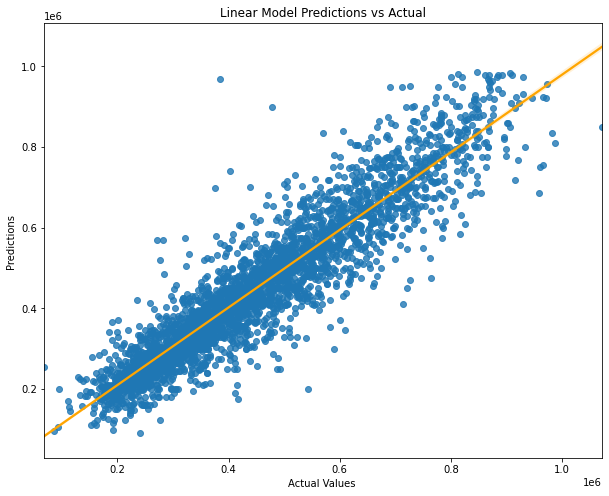

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) R2 score: 0.8728735153932954
Mean Absolute Error: 46507.459060424844
Mean Squared Error: 65422.66652915558


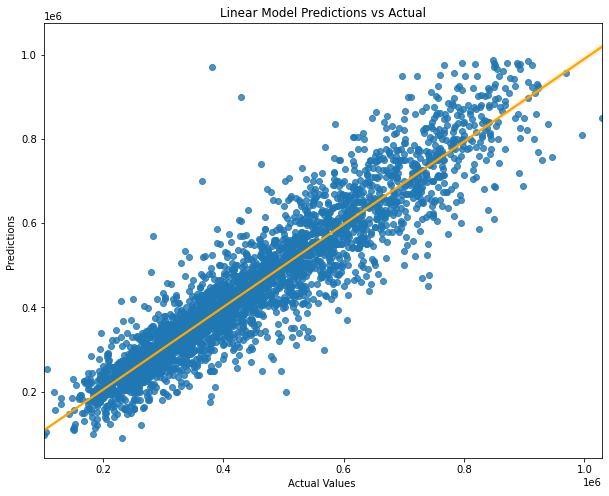

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) R2 score: 0.8834705290153213
Mean Absolute Error: 44256.123964778904
Mean Squared Error: 62636.59052604274


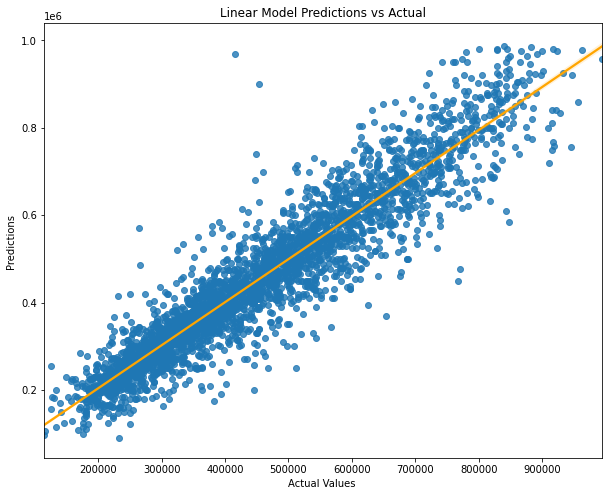

--------------------------------------------------------------------------------------------------------
TAA DAAA!! AND THE WINNER IIIISSSSS:
--------------------------------------------------------------------------------------------------------
Best R2: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 0.8834705290153213
Best Mean Absolute Error: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, 

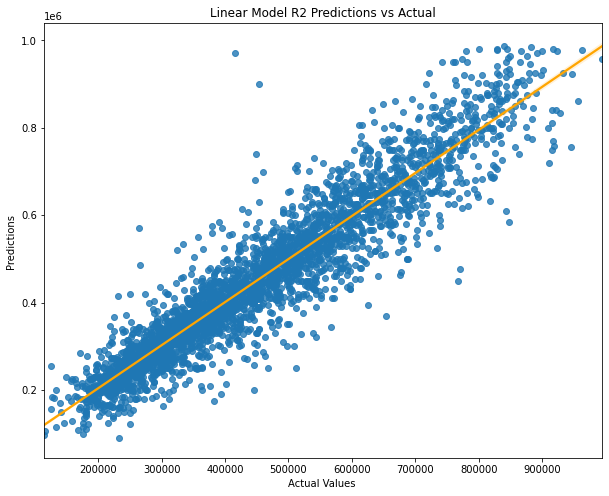

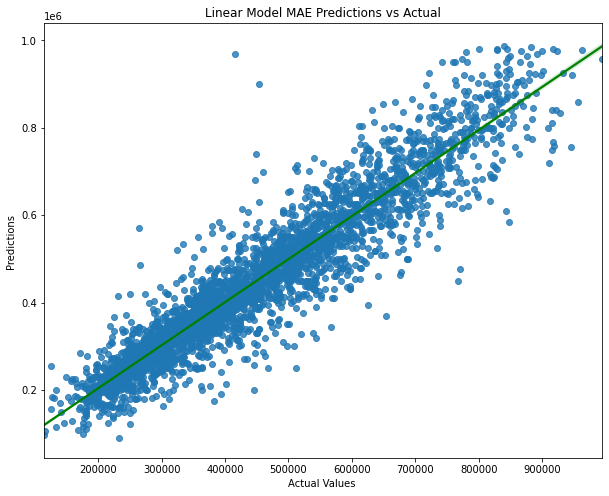

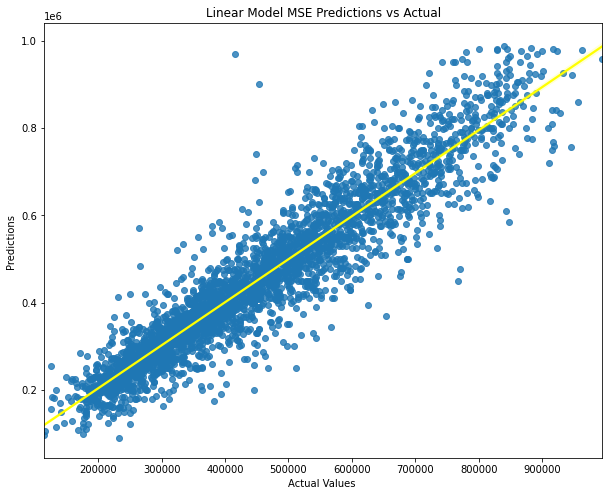

In [100]:
best_model = funky_function4_1_4_1(data, model_list)
with open('model.pickle', 'wb') as file:
    pickle.dump(best_model, file)

### Running a manual test just in case :)
Train r2 score:  0.9314533787104189
Test r2 score:  0.8708967890519163
Train RMSE: 45200.3107
Test RMSE: 65929.3425
Train MAE: 32799.9513
Test MAE: 47095.3014


In [98]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error as MSE
scaler = StandardScaler()
   
X = pd.get_dummies(data.drop('price', axis=1))
y = data['price']

X_train, X_test, y_train_, y_test_ = train_test_split(X, y, test_size=0.25, random_state=42)

scaler.fit(X_train)
X_train_, X_test_ = (scaler.transform(X_train), scaler.transform(X_test))

xgb_model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model2.fit(X_train_, y_train_, early_stopping_rounds=5, 
             eval_set=[(X_test_, y_test_)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train_)
y_pred2 = xgb_model2.predict(X_test_)

print('Train r2 score: ', r2_score(y_train_pred2, y_train_))
print('Test r2 score: ', r2_score(y_test_, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train_)
test_mse2 = mean_squared_error(y_pred2, y_test_)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
train_mae = mean_absolute_error(y_train_pred2, y_train_)
test_mae = mean_absolute_error(y_pred2, y_test_)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)
print('Train MAE: %.4f' % train_mae)
print('Test MAE: %.4f' % test_mae)

Train r2 score:  0.9294096791224637
Test r2 score:  0.8808400738955493
Train RMSE: 45617.6742
Test RMSE: 63339.6027
Train MAE: 32885.8034
Test MAE: 45030.6359


In [18]:
data.columns

Index(['data', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zip_code', 'lat', 'lon',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [21]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error as MSE
scaler = StandardScaler()
   
X = pd.get_dummies(data.drop('price', axis=1))
y = data['price']

X_train, X_test, y_train_, y_test_ = train_test_split(X, y, test_size=0.25, random_state=42)

scaler.fit(X_train)
X_train_, X_test_ = (scaler.transform(X_train), scaler.transform(X_test))

xgb_model2 = XGBRegressor(n_estimators=100)
xgb_model2.fit(X_train_, y_train_, early_stopping_rounds=5, 
             eval_set=[(X_test_, y_test_)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train_)
y_pred2 = xgb_model2.predict(X_test_)

print('Train r2 score: ', r2_score(y_train_pred2, y_train_))
print('Test r2 score: ', r2_score(y_test_, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train_)
test_mse2 = mean_squared_error(y_pred2, y_test_)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
train_mae = mean_absolute_error(y_train_pred2, y_train_)
test_mae = mean_absolute_error(y_pred2, y_test_)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)
print('Train MAE: %.4f' % train_mae)
print('Test MAE: %.4f' % test_mae)

Train r2 score:  0.9182124929608856
Test r2 score:  0.8693831747187218
Train RMSE: 48945.4009
Test RMSE: 66314.6962
Train MAE: 35667.0157
Test MAE: 47372.6546
